In [1]:
!pip install higher

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import higher

import sys
sys.path.append('helpers')


## Meta Learning for Classification


Now suppose we wish to learn a good set of feature weights for performing classification on tasks. Consider the same setup as the regression problem but now our training data consists of $(x_i, z_i)$ where $z_i = sgn(f(x_i))$. The $f$ here refers to the underlying true function that is sampled from a distribution $\mathcal{D}_T$ as before.  

For a given set of feature weights with corresponding weighted features $\phi_w$, we solve the logistic regression problem to learn a set of coefficients $\alpha$ using which on a test point $x_{test}$ we assign the label $\hat{z}_{test} = sgn(\langle \alpha, \phi_w(x_{test}) \rangle)$. The test loss of interest is the classification error $\mathbb{E}[\hat{z}_{test} \neq z_{test}]$ where the expectation is over the randomness in the test point. Since the test loss is not differentiable we use the logistic loss while training (logistic regression).

Next we describe how we learn the coefficients $\alpha \in \mathbb{R}^d$. We have training data $(x_i, z_i)$ where $x_i$ is a data point and  $z_i$ is its label from ${+1, -1}$. For each point $x_i$ we have a set of weighted features $\phi_w(x_i)$. 


Recall a standard logistic function is defined as $$g(t) = \frac{1}{e^{-t}+1}$$ https://en.wikipedia.org/wiki/Logistic_function which has the nice property of $g(-t) = 1-g(t)$, hence we can use it to model the binary probability: given a value $t$ that possibly comes from two classes with labels $+1$ and $-1$, we can model the probability of $t$ belonging to class $+1$ as $p_1(t) = g(t)$, and conviniently get $1-g(t) = p_{-1}(t)$. In our classification problem setup, this $t = z_i\langle \alpha, \phi_w(x_i) \rangle$. Thus $g(t)$ can be thought of as the probability of "correct classification", because for a correct prediction, $t = z_i\langle \alpha, x_i \rangle$ will always be positive, and its probability $g(t)$ will be properly capped at 1. 

Therefore, to maximize the total log probability of predicting the correct label on all datapoints we find the $\alpha$ that maximizes 
$$\Sigma_i \log{ \frac{1}{e^{-z_i\langle \alpha, \phi_w(x_i) \rangle}+1} }.$$ Flipping the sign, this is equivalent to finding the $\alpha$ that  minimizes the loss 
$$ - \Sigma_i \log{ \frac{1}{e^{-z_i\langle \alpha, \phi_w(x_i) \rangle}+1} },$$ as listed here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression 

One way to find this $\alpha$ is by using gradient descent similar to what we did in the regression setting. In the regression setting we used the squared loss but in the classification setting we use the logistic loss. 

For this problem we give code for plotting and data generation but rest of the functions need to be written. 

### (g) Start out by copy pasting the functions using for the regression problem using sgd from utils_reg into utils_classification.  
Any function that has \_reg in its name might require changes for the classification problem.  We provide the following functions for plotting and data generation that you do not have to modify:

1. get_post_data_classification
2. visualize_prediction_classification
3. visualize_test_loss_classification

### First do not modify contents of the copy pasted functions except to rename them and in the following two places 
1. noise_prob should be read in from params_dict in the function meta_learning_classification
2. visualize_test_loss_classification should be called with the argument noise_prob instead of noise_std

### Then run the cell below. 
This should run without any errors though the meta learning is being done on regression tasks and test losses are being computed on the regression tasks. 

{'seed': 7, 'n_train_inner': 32, 'n_train_meta': 64, 'n_train_post': 32, 'n_test_post': 1000, 'x_type': 'uniform_random', 'd': 501, 'phi_type': 'fourier', 'noise_prob': 0.0, 'optimizer_type': 'SGD', 'k_idx': array([ 5,  6,  7,  8,  9, 10]), 'stepsize_meta': 0.01, 'num_inner_tasks': 5, 'num_tasks_test': 10, 'num_stats': 10, 'num_iterations': 100, 'num_n_train_post_range': 40, 'num_gd_steps': 5, 'stepsize_inner': 0.01}
----------------------------------------------------------------------
Iteration:  0


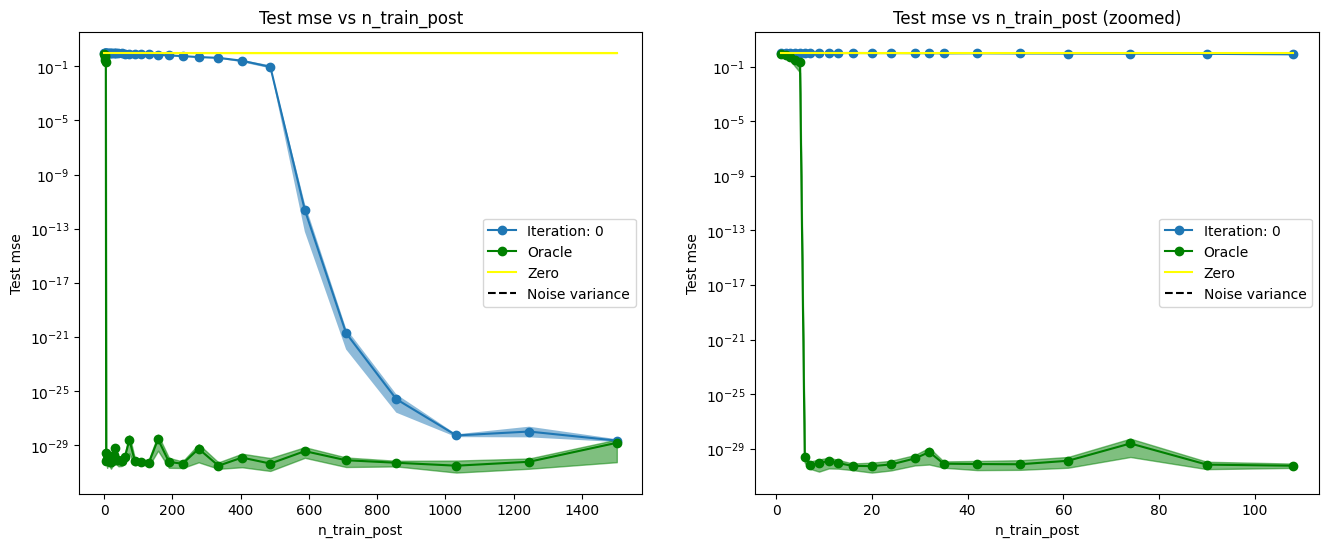

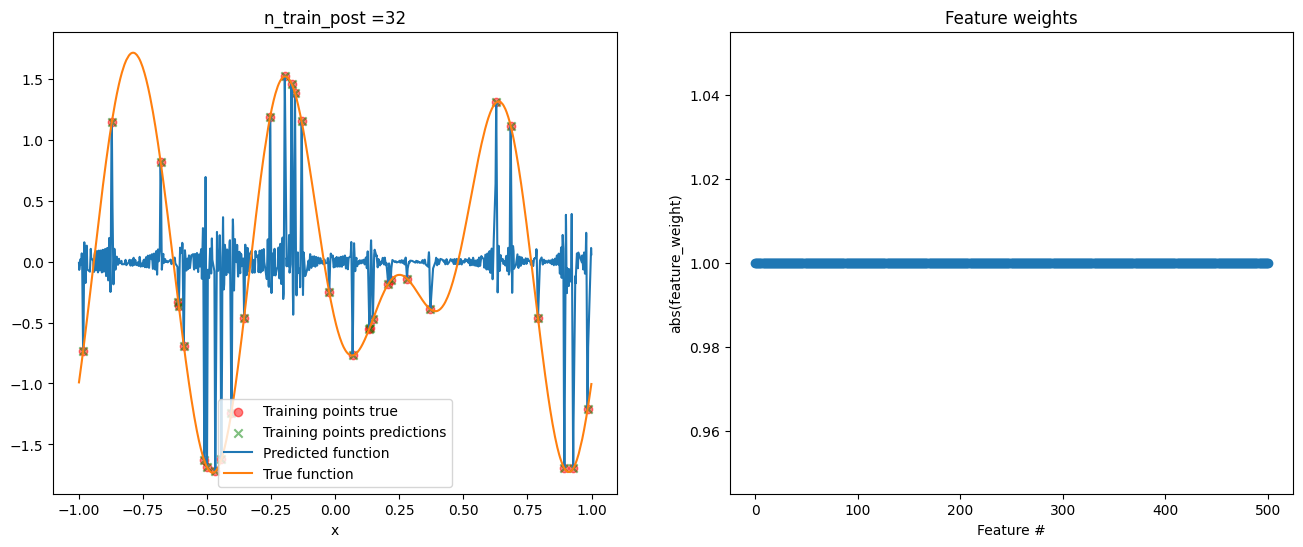

----------------------------------------------------------------------
Iteration:  10


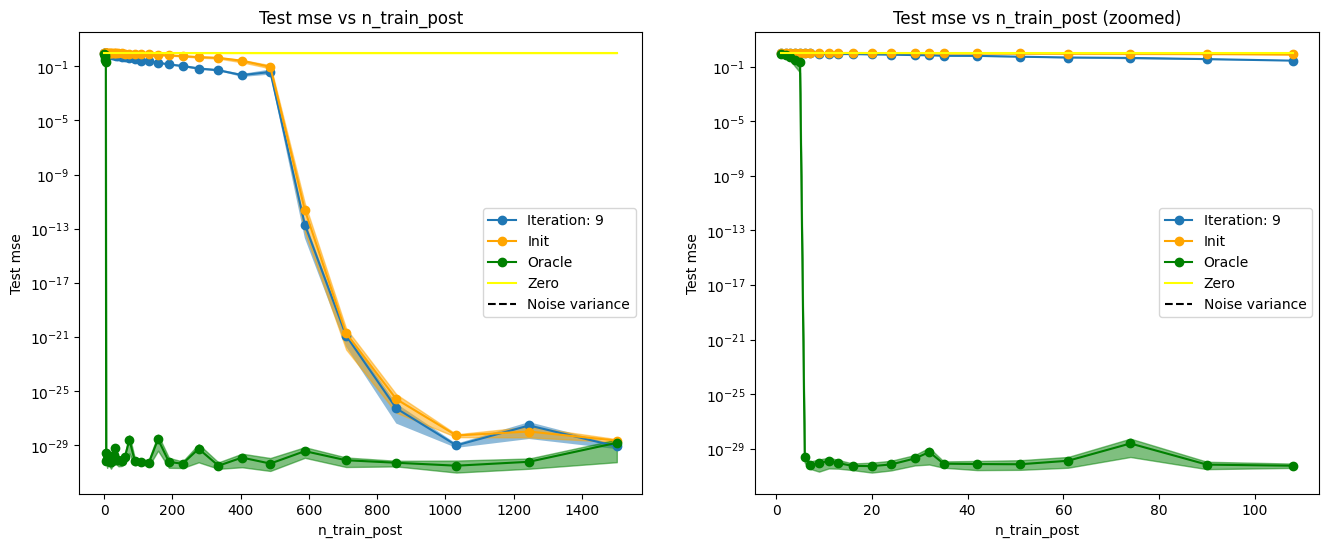

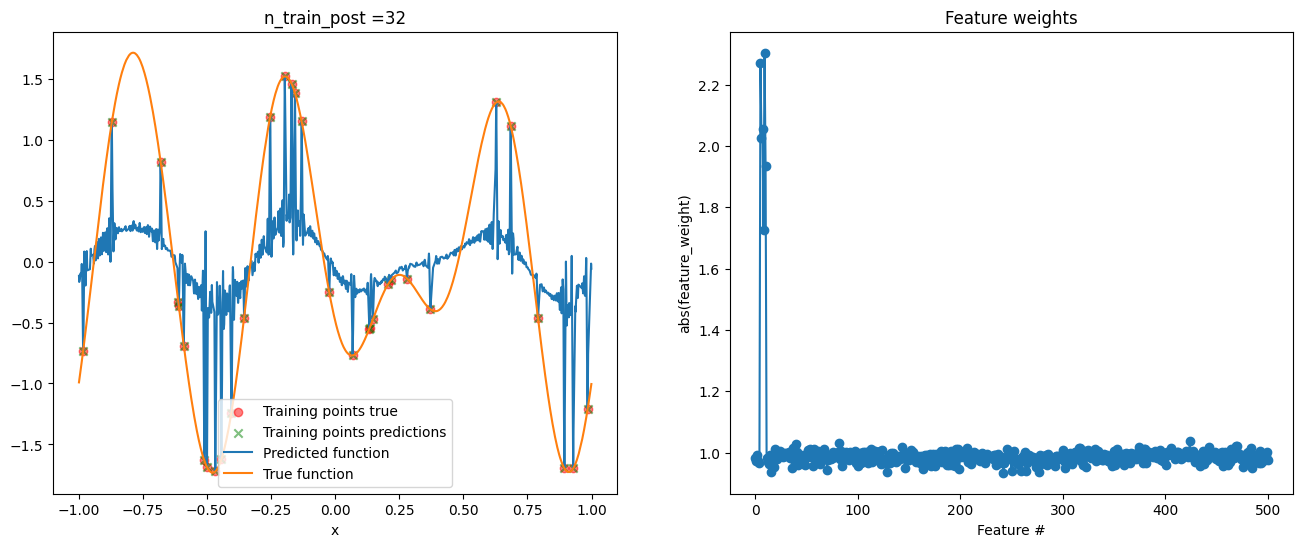

----------------------------------------------------------------------
Iteration:  20


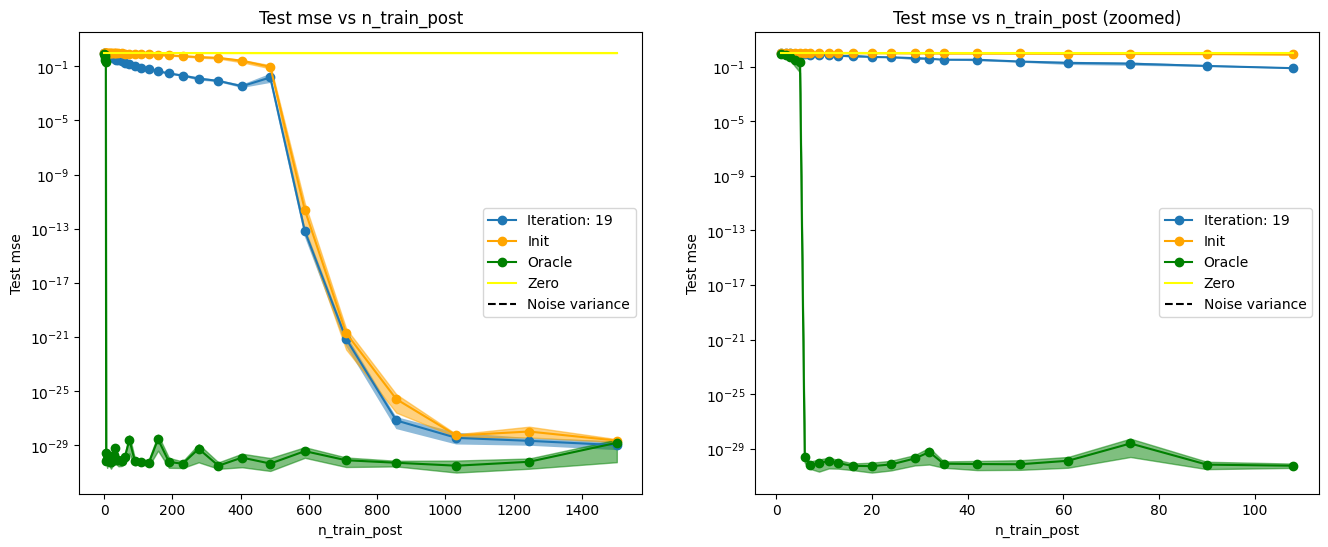

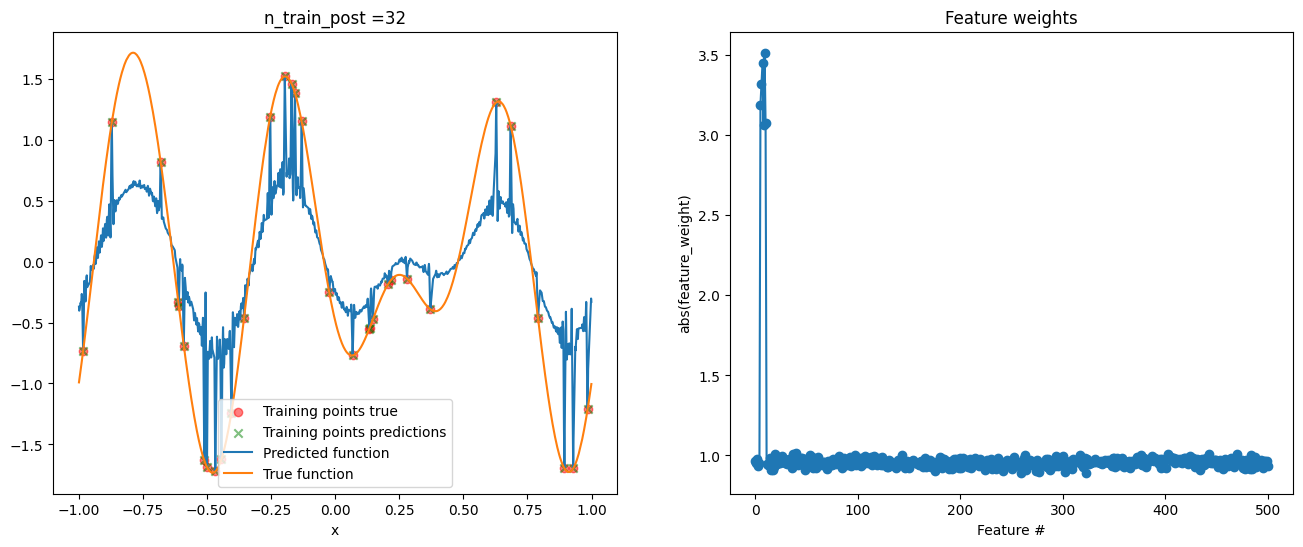

----------------------------------------------------------------------
Iteration:  30


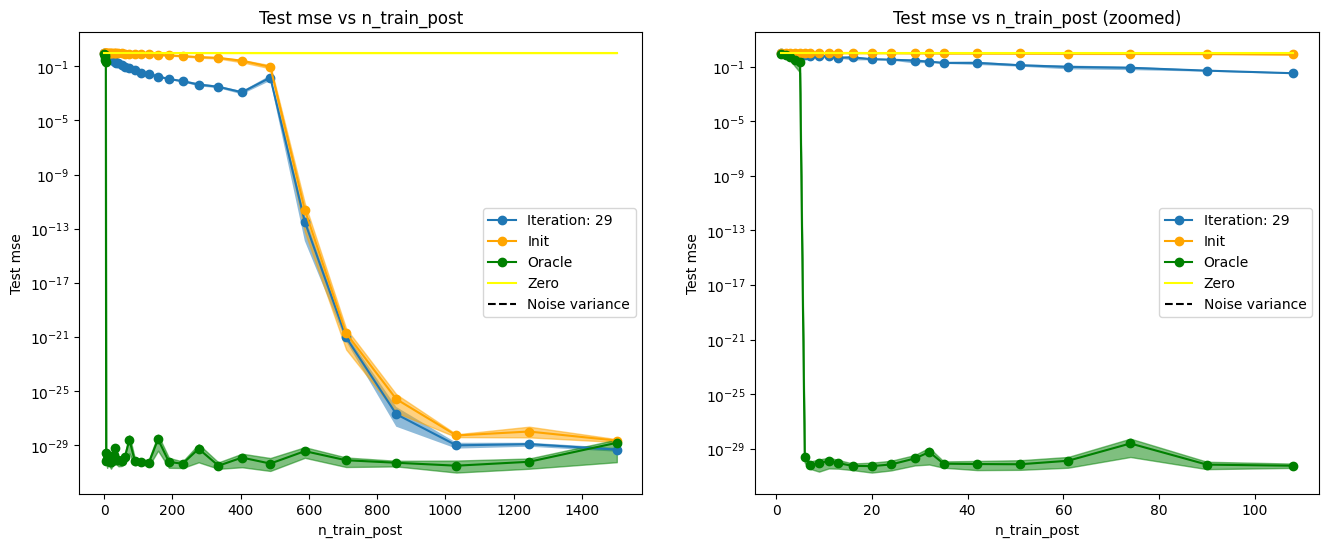

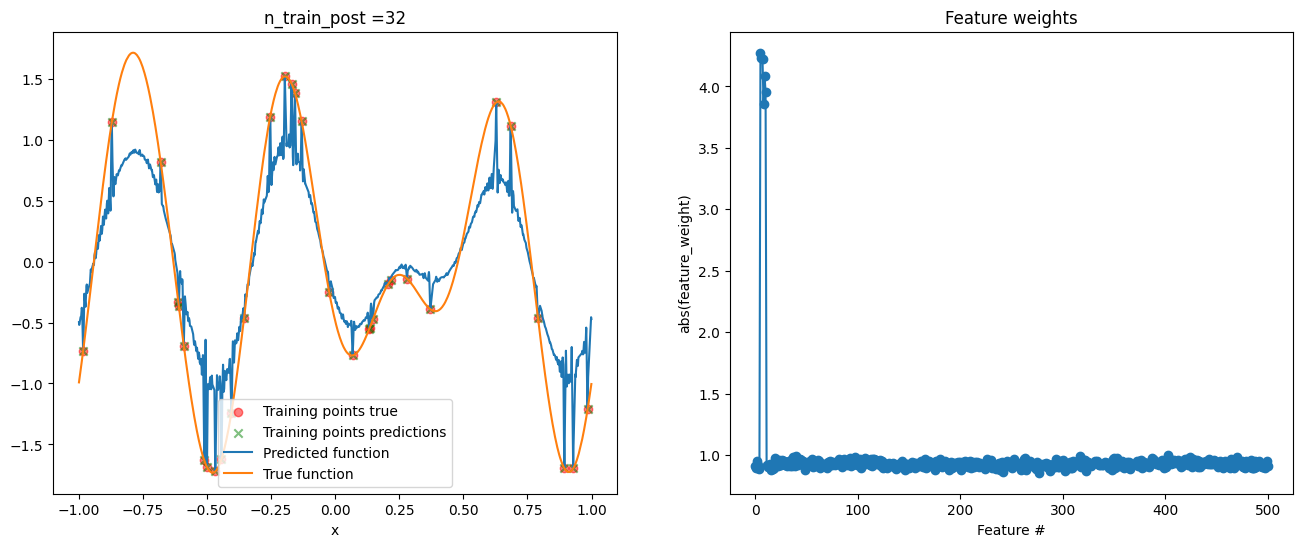

----------------------------------------------------------------------
Iteration:  40


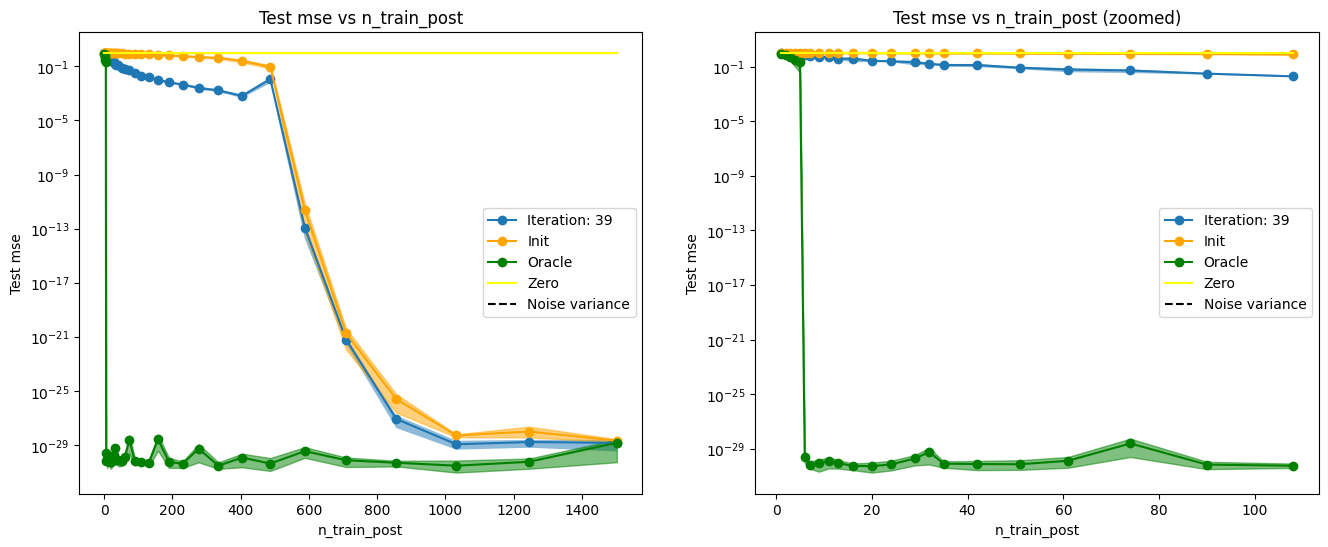

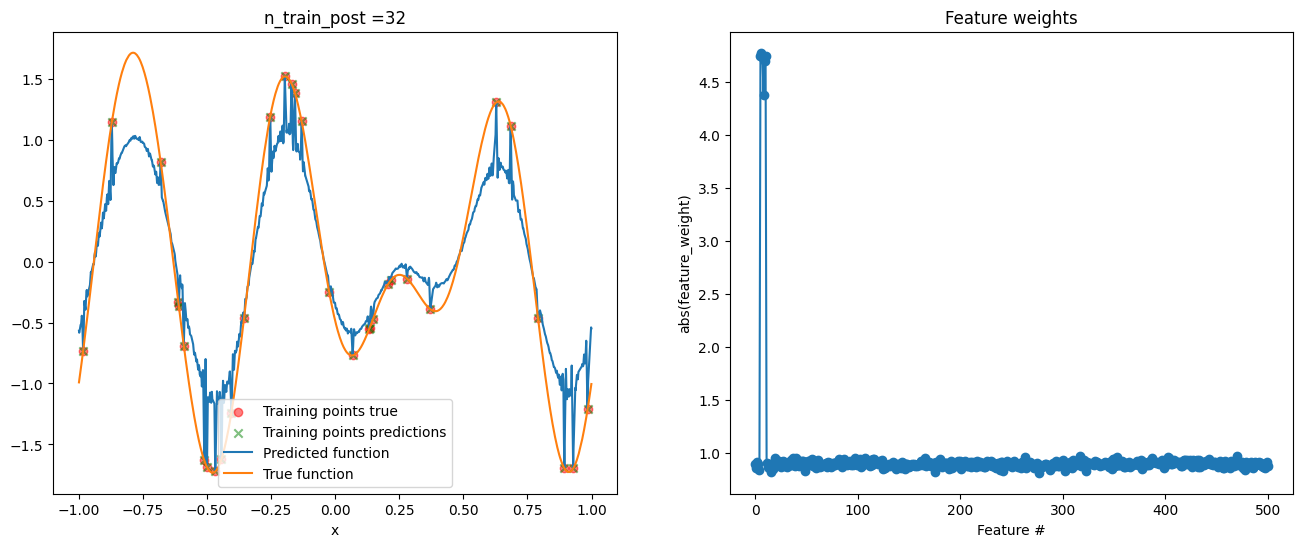

----------------------------------------------------------------------
Iteration:  50


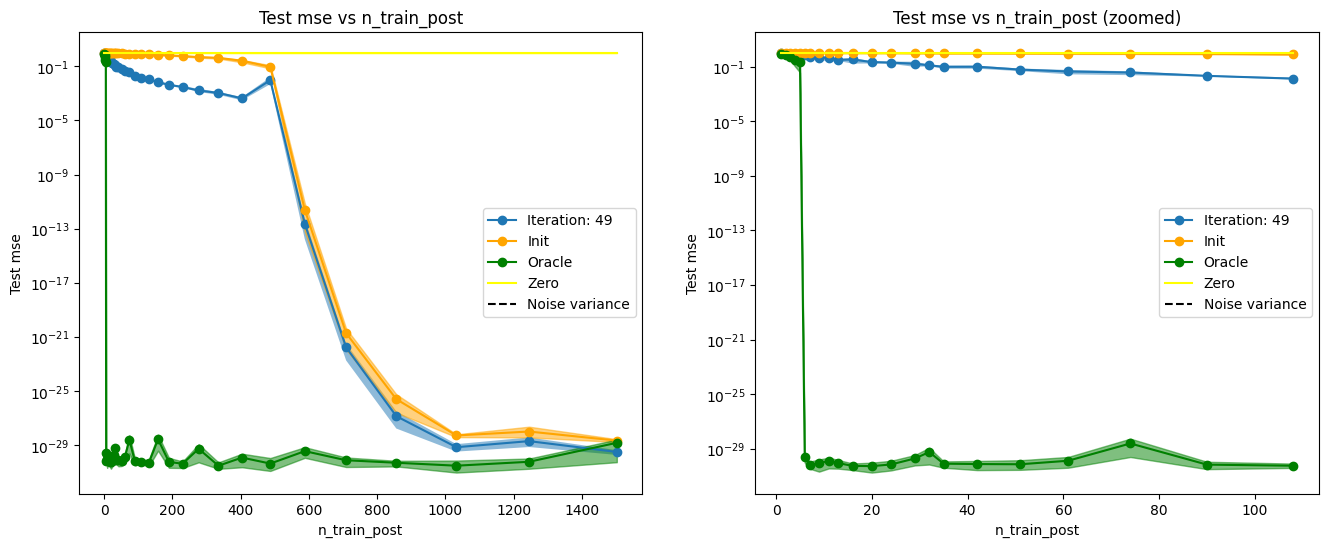

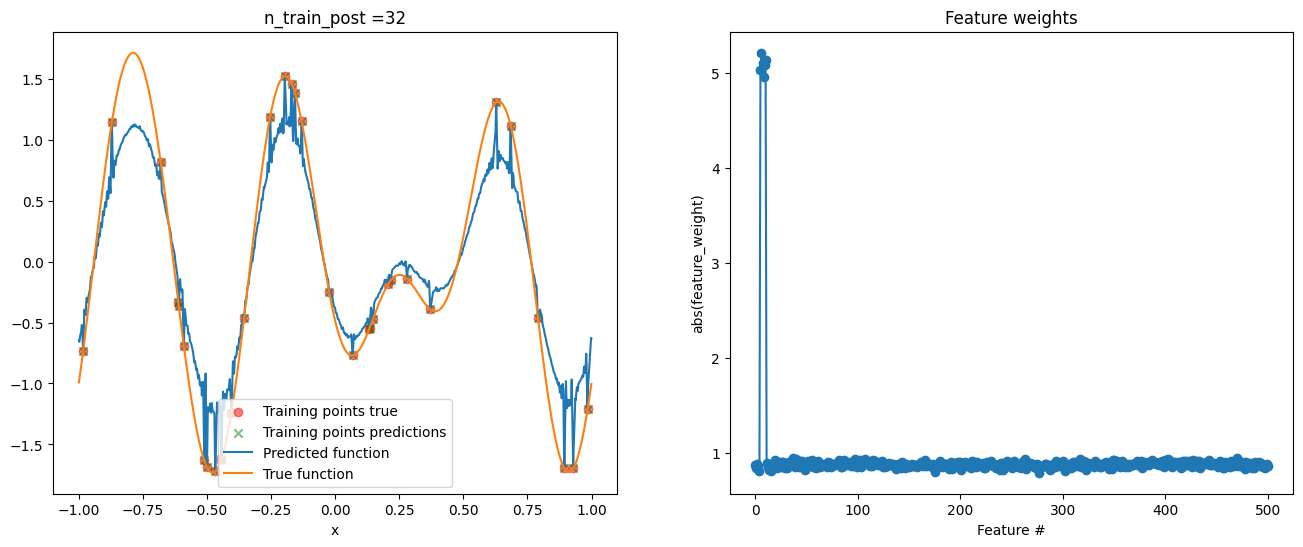

----------------------------------------------------------------------
Iteration:  60


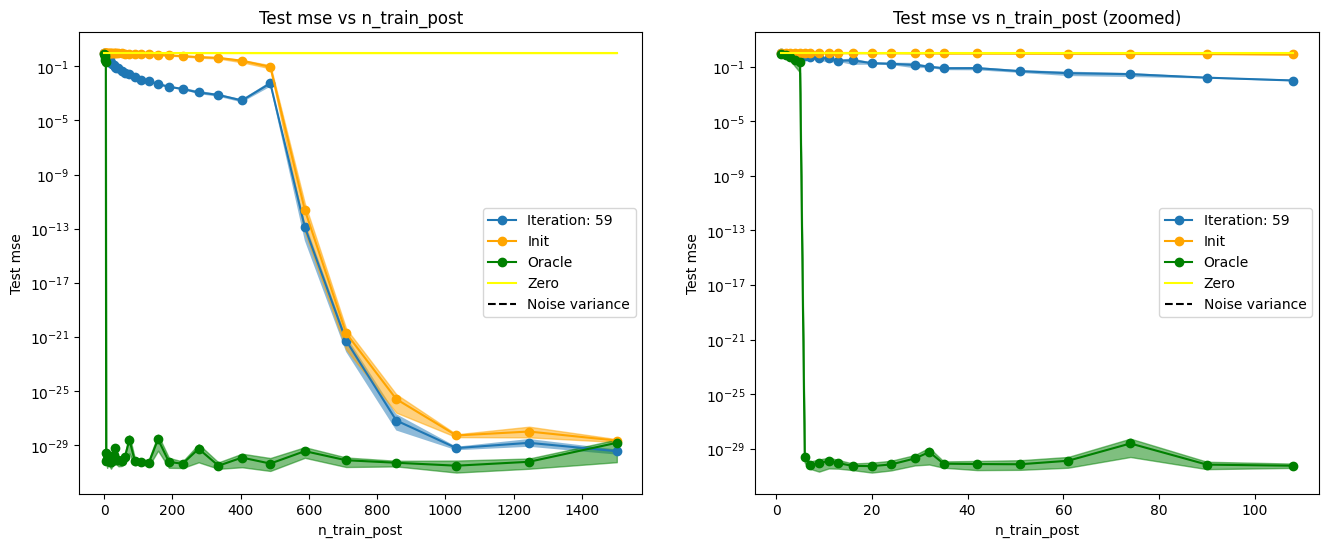

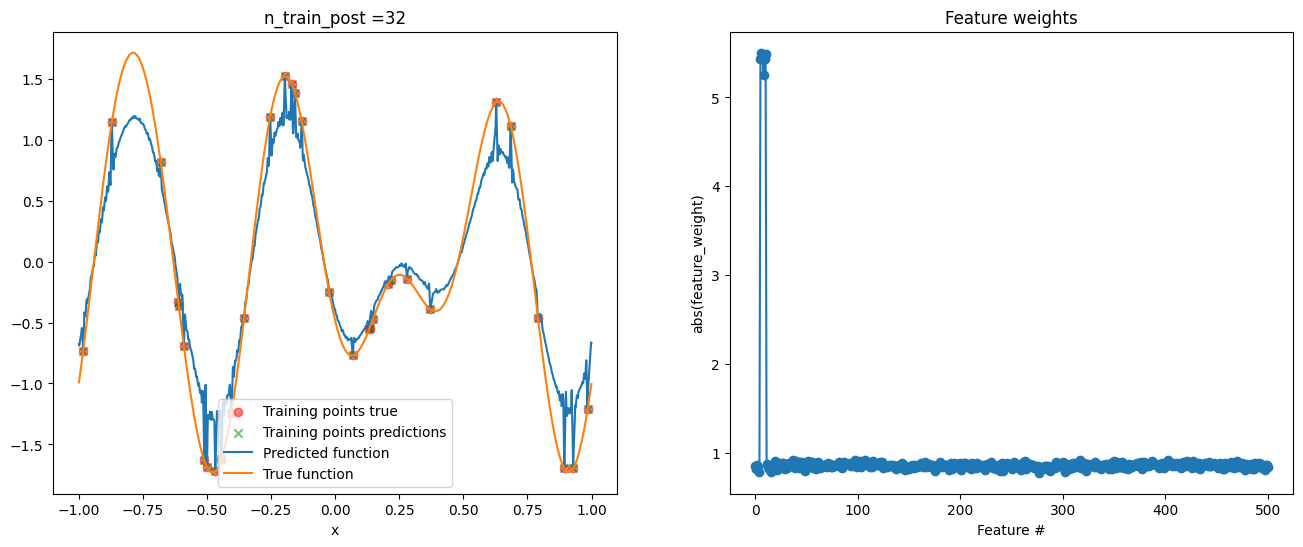

----------------------------------------------------------------------
Iteration:  70


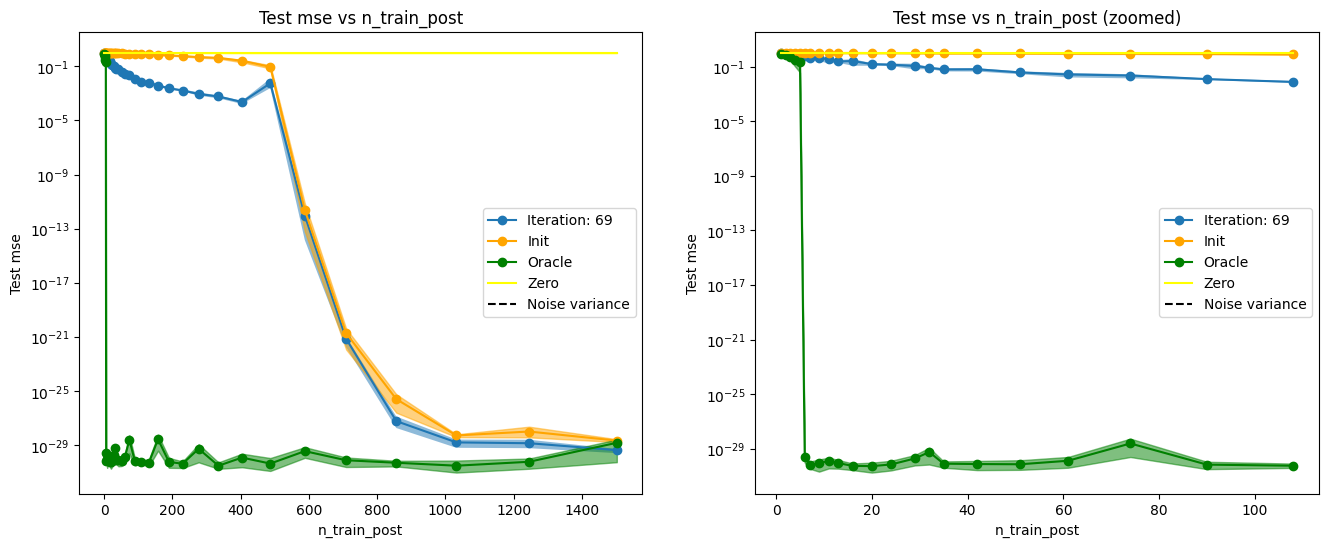

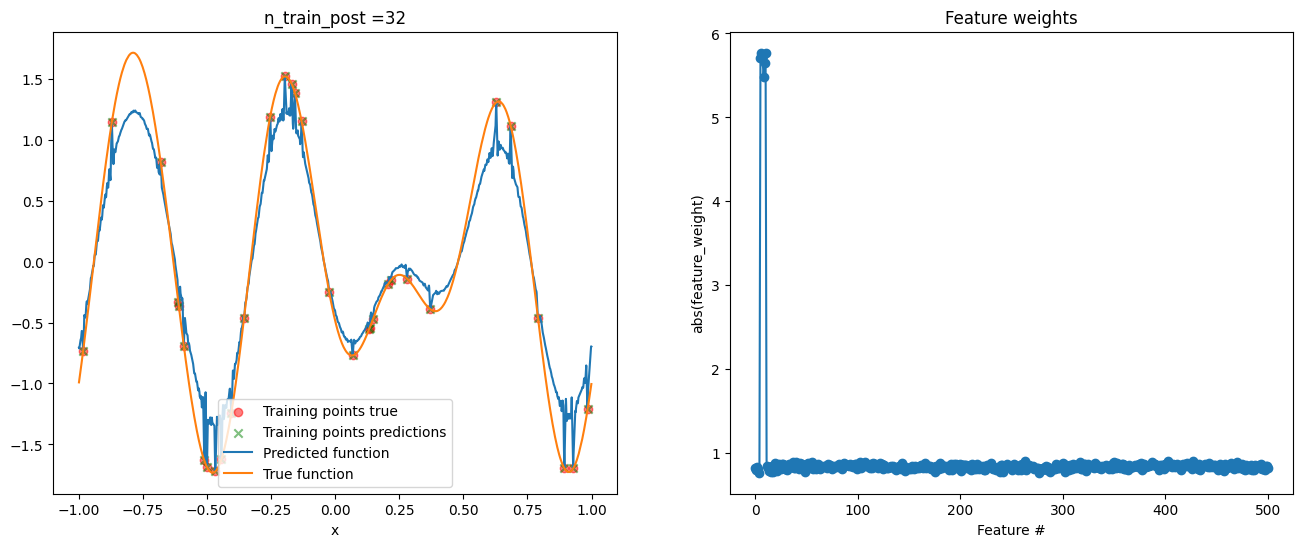

----------------------------------------------------------------------
Iteration:  80


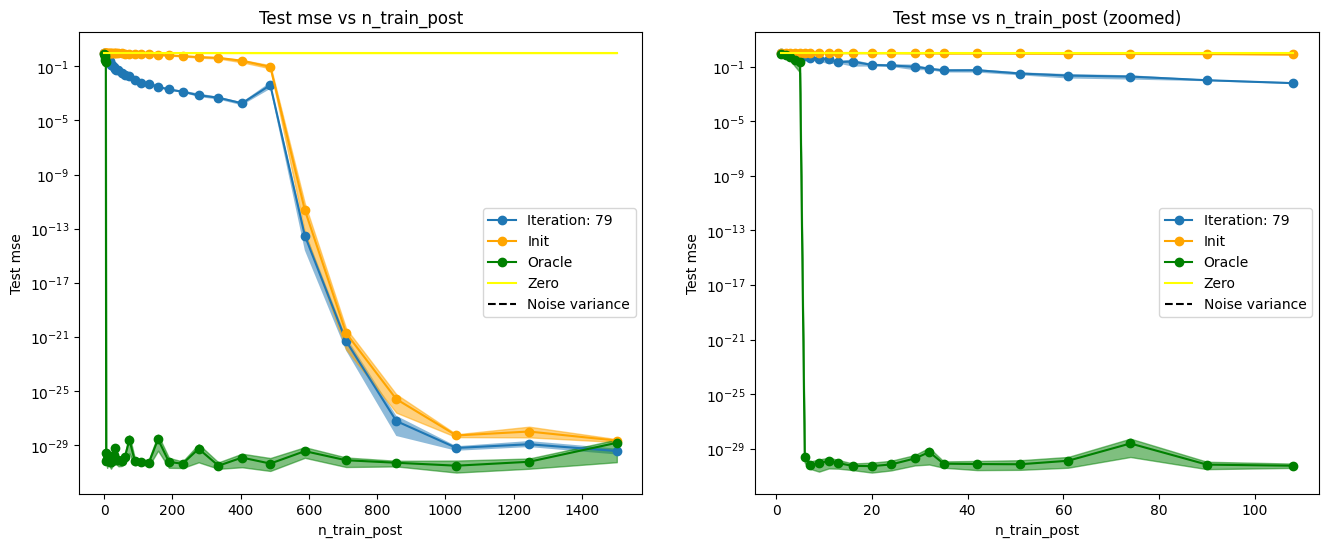

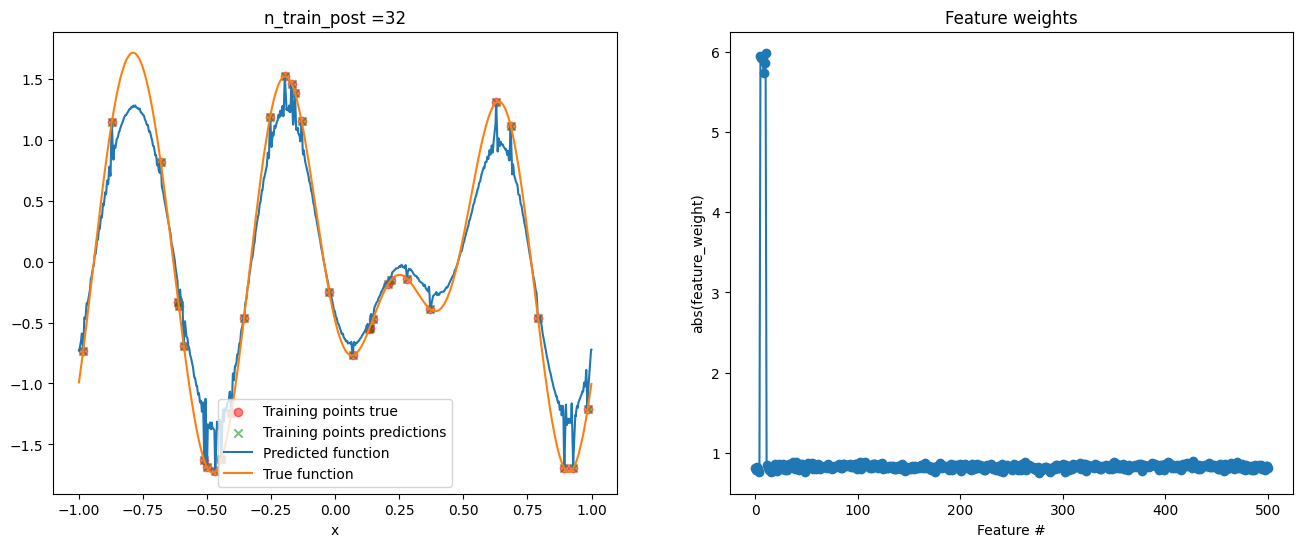

----------------------------------------------------------------------
Iteration:  90


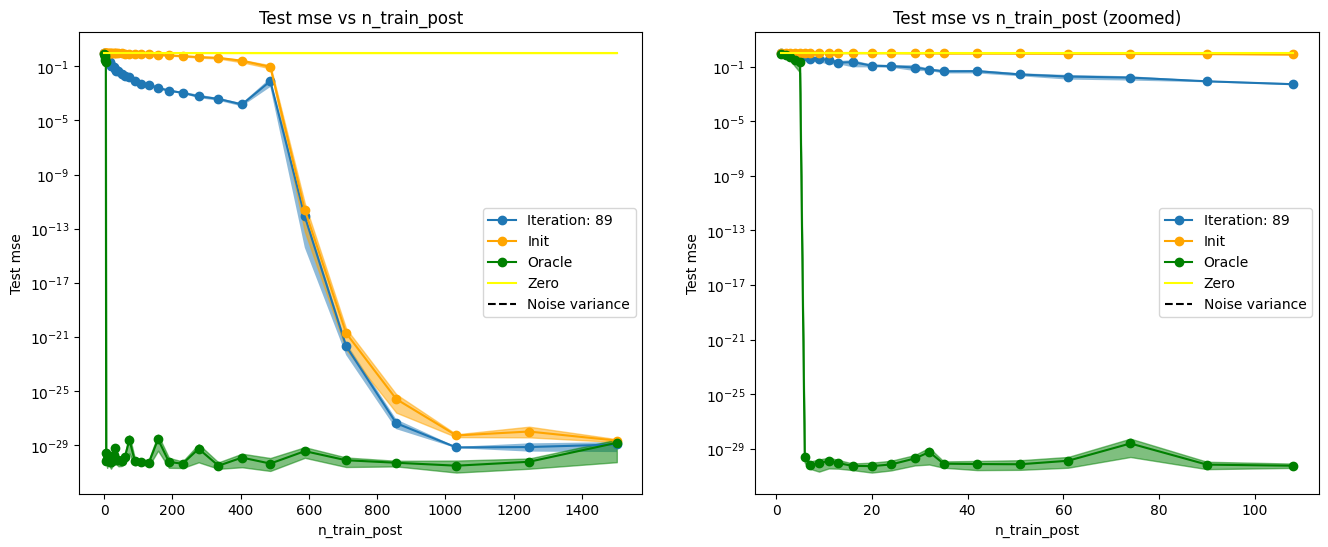

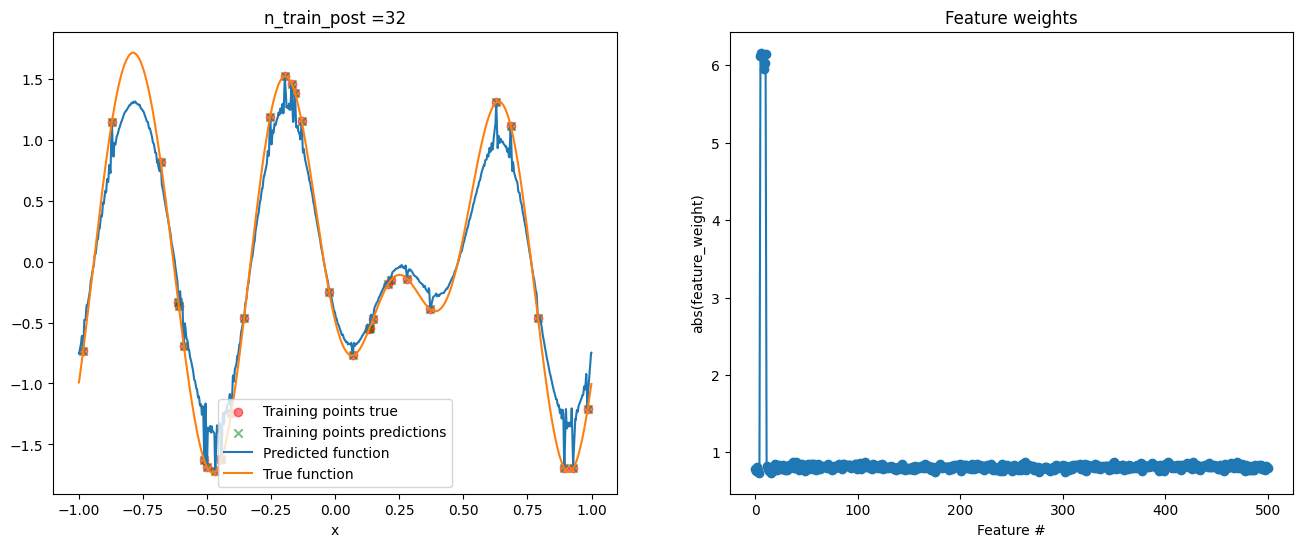

----------------------------------------------------------------------
Iteration:  100


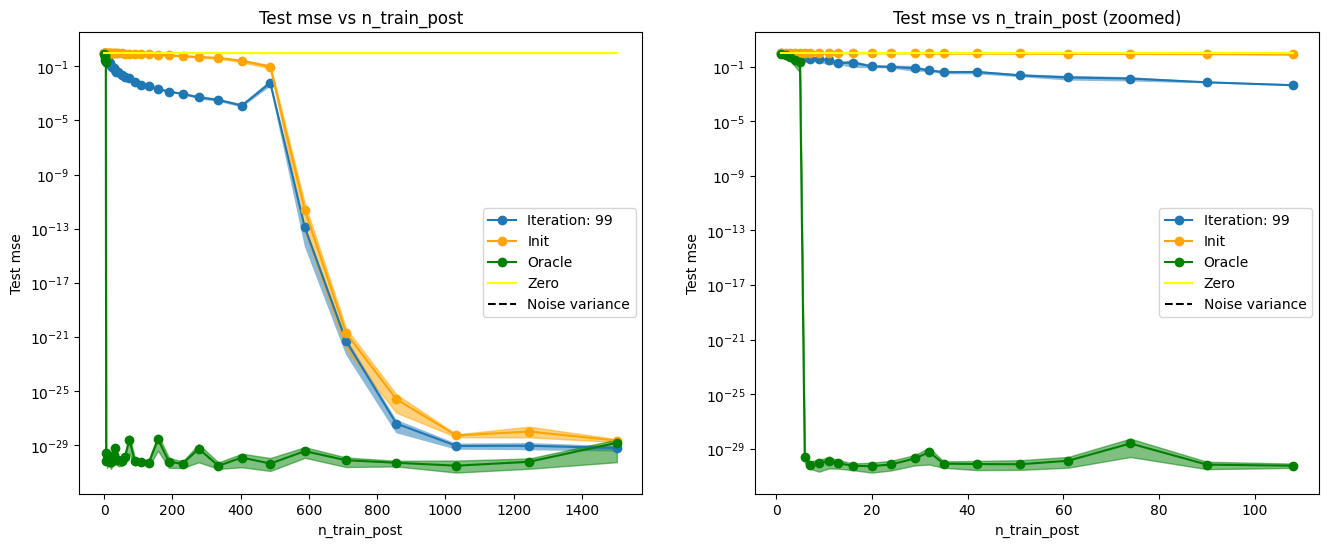

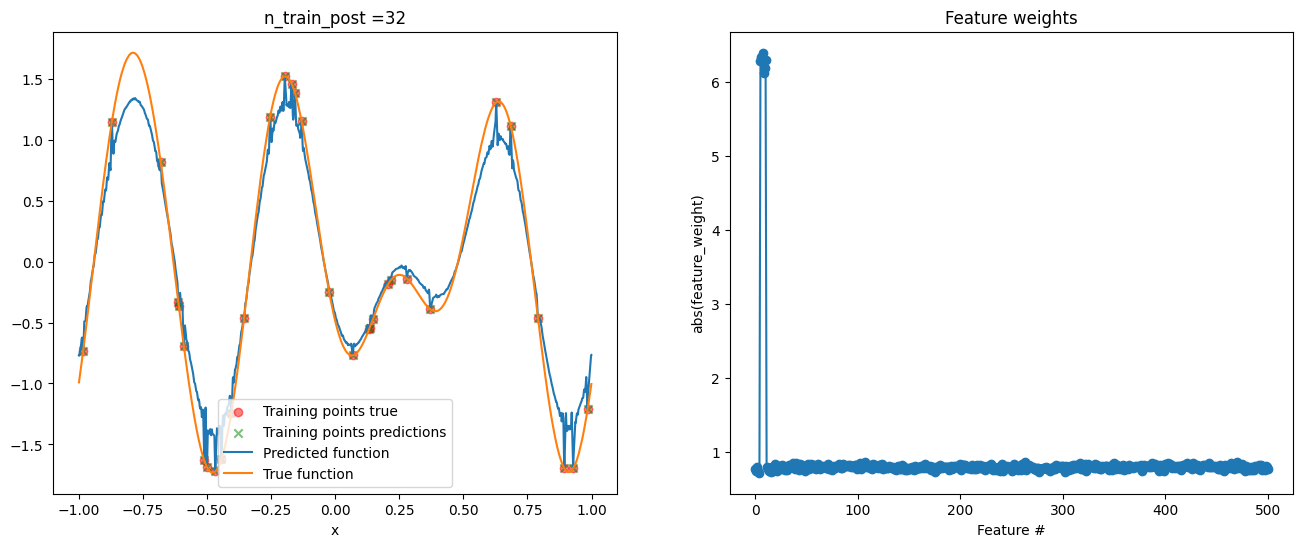

In [3]:
from utils_classification import meta_learning_classification
import warnings; warnings.simplefilter('ignore')
def get_params_dict_classification():
    params_dict = {
        #Parameters
        'seed':7,
        'n_train_inner':32, #Number of training samples for training inner task
        'n_train_meta':64, #Number of training samples for updating the meta parameter

        'n_train_post':32, #Number of training samples used after meta training has been done to learn the weights
        'n_test_post':1000, #Number of samples used for plotting and evaluating test performance after meta training has been done 
    
        'x_type':'uniform_random', #sampling time for inner and post training tasks
        # 'x_type':'grid', #sampling time for training tasks

        'd':501, #Number of features
        'phi_type':'fourier', #Feature type
        'noise_prob':0.0, #standard deviation of awgn noise added during training 
        'optimizer_type':'SGD', #Optimizer type for meta updates Can be either SGD or Adam
        'k_idx':np.arange(5,11), #Frequency range present in tasks during meta training
        'stepsize_meta':1e-2, #Stepsize used for meta updates

        'num_inner_tasks':5, #Number of inner tasks for each meta update   
        'num_tasks_test':10, #Number of tasks to test on
        'num_stats': 10, #Determines how often we collect stats

        'num_iterations':100, #Iterations for training meta parameter
        'num_n_train_post_range':40, #How many points do we use to generative test loss vs n_train_post curve


       
        'num_gd_steps':5, #Number of GD steps in inner task to move towards min norm ls solution

    }
    return params_dict

params_dict = get_params_dict_classification()
cparams_dict = params_dict.copy()
stepsize_inner = 1e-2
cparams_dict['stepsize_inner'] = stepsize_inner
print(cparams_dict)
meta_learning_classification(cparams_dict)

### (h) Now modify the functions so as to perform meta learning for the classification task using logistic loss and to test performance on classification task. 

The error of interest is the classification error.  Make sure that for training you only use $z_i = sgn(f(x_i))$ i.e only the +1 or -1 label and not the real values, $y_i = f(x_i)$. In the inner loop for meta training you will have to perform gradient descent on the logistic loss in a manner similar to that in the regression setting so as to preserve gradients on the feature weights. For testing you are free to use package based solvers like sklearn.linear_model.LogisticRegression (check solve_logistic function in utils.py). 

### Then run the cell below and answer the following questions.

1. Based on the plot of classification error vs n_train_post, how do the meta-learned feature weights perform compared to the case where all feature weights are 1? How do the meta-learned feature weights perform compared to the oracle (that performs logistic regression only using the features present in the data)? 

2. By looking at the evolution of the feature-weights with time as we perform meta-learning can you justify the improvement in performance? In particular, can you explain why some feature weights are being sent towards zero?



----------------------------------------------------------------------
Iteration:  0


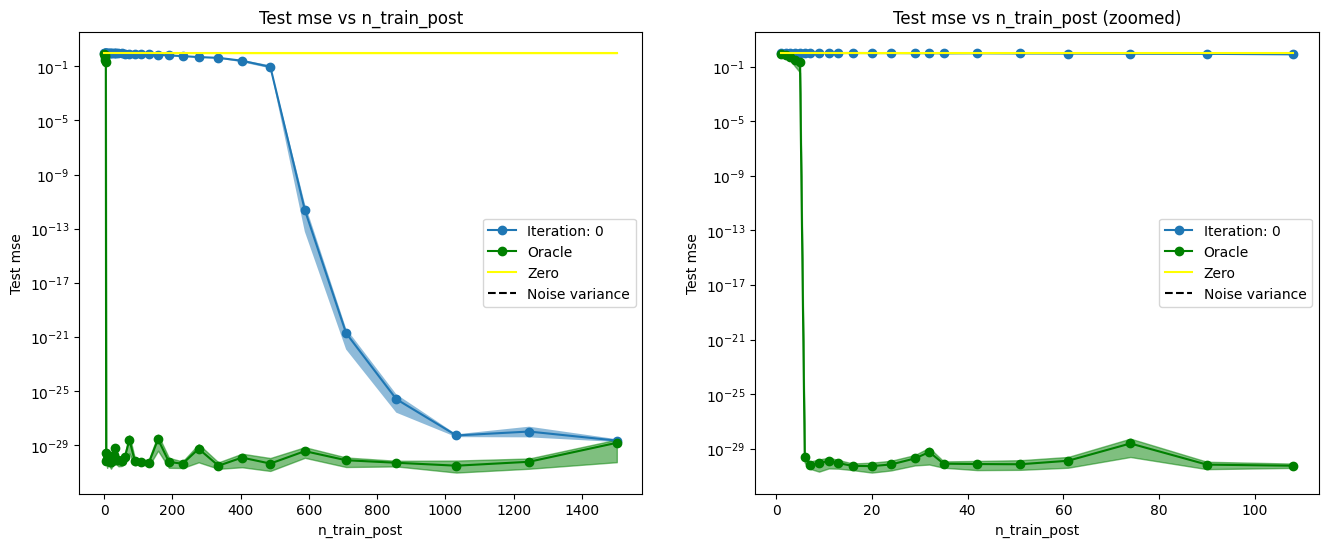

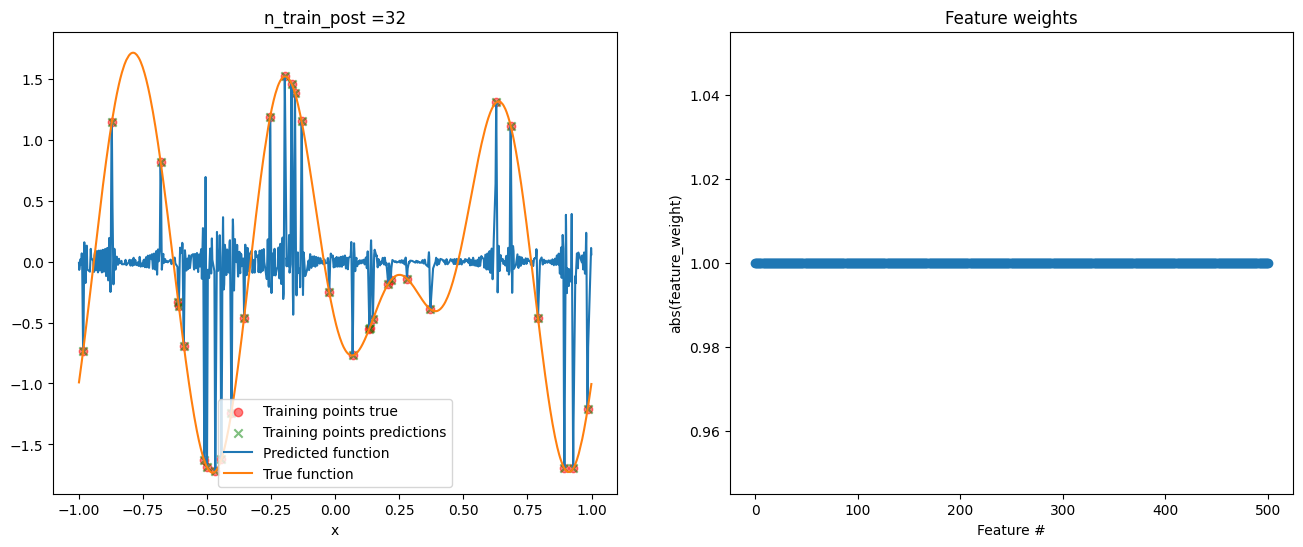

----------------------------------------------------------------------
Iteration:  10


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [4]:
from utils_classification import meta_learning_classification
import warnings; warnings.simplefilter('ignore')
def get_params_dict_classification():
    params_dict = {
        #Parameters
        'seed':7,
        'n_train_inner':32, #Number of training samples for training inner task
        'n_train_meta':64, #Number of training samples for updating the meta parameter

        'n_train_post':32, #Number of training samples used after meta training has been done to learn the weights
        'n_test_post':1000, #Number of samples used for plotting and evaluating test performance after meta training has been done 
    
        'x_type':'uniform_random', #sampling time for inner and post training tasks
        # 'x_type':'grid', #sampling time for training tasks

        'd':501, #Number of features
        'phi_type':'fourier', #Feature type
        'noise_prob':0.0, #standard deviation of awgn noise added during training 
        'optimizer_type':'SGD', #Optimizer type for meta updates Can be either SGD or Adam
        'k_idx':np.arange(5,11), #Frequency range present in tasks during meta training
        'stepsize_meta':1e-2, #Stepsize used for meta updates

        'num_inner_tasks':5, #Number of inner tasks for each meta update   
        'num_tasks_test':10, #Number of tasks to test on
        'num_stats': 10, #Determines how often we collect stats

        'num_iterations':100, #Iterations for training meta parameter
        'num_n_train_post_range':40, #How many points do we use to generative test loss vs n_train_post curve


       
        'num_gd_steps':5, #Number of GD steps in inner task to move towards min norm ls solution

    }
    return params_dict

params_dict = get_params_dict_classification()
cparams_dict = params_dict.copy()
stepsize_inner = 3e-1
cparams_dict['stepsize_inner'] = stepsize_inner

meta_learning_classification(cparams_dict)

After doing the required changes this is what each plot contains:

On the first row, we plot the test classification error w.r.t. the number of datapoints used for logistic regression after meta training is done. The green curve plots test loss from the oracle, i.e. using only the features present in the true function, the blue curve uses feature weights learned at the current iteration of  meta training, and again we use the orange curve to mark performance at initialization with the all ones feature weight. The yellow curve is the baseline where we guess the same label for all points (and thus 0.5 classification error). The figure on the right in the first row is a zoomed-in version of the figure on the left. Like in the regression setting we plot the average, 10th and 90th percentile of the classification error over 10 tasks. 

On the second row to the left, the true sign labels are shown in orange and the predicted sign labels are shown in green. The labels corresponding to the training points and our predictions on training points are given by the red dots and green crosses respectively. The brown curve shows the underlying true function and the purple curve shows the function given by $\langle \alpha, x \rangle$ after $\alpha$ has been normalized to have unit norm.

On the second row to the right we plot the feature weights at the current iteration that are being meta-learned. 